In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import jax

# Generazione Dati

In [19]:
from IPython.utils.sysinfo import num_cpus

# numero di cluster
K=6

# dimensione del campione
d=2

# numero di sample
N=1000

key = random.PRNGKey(2023)
# vectors of mean of clusters
sigma=1
mu=random.normal(key,(K,d))*sigma

# cluster assignment
key = random.PRNGKey(2)
c=random.categorical(key,(1/K)*jnp.ones(shape=(K,)),axis=0,shape=(N,))
C=np.zeros(shape=(N,K))
for i in range(N):
  C[i,c[i]]=1
C=jnp.array(C)

# Data
X=jnp.matmul(C,mu)+random.normal(key,(N,d))

# Variational Inference

We construct the model for our VI algorithm, we stick to the notation of the paper. Our model is described by:

\begin{align*}
    \mu_k\ \mid x &\stackrel{\tiny\mbox{}}{\sim} \mathcal{N}\left(m_k, s^2_k\right) \\
    x_i \mid c_i,μ &\sim \mathcal{N}\left(c^T_iμ, 1\right) \\
    \mu_k &\stackrel{\tiny\mbox{}}{\sim}\mathcal{N}\left(0, \sigma^2\right) \\
\end{align*}

We work in the family of Gaussian distribution for this first attempt, then we could expand it to exponential family.


Il paper descrive l'algoritmo in un caso 1D, dobbiamo adattarlo in un generico caso multidimensionale, io ho iniziato implementando il caso unidimensionale nell'algoritmo copiandolo dal paper, consapevole che andrà adattato

In [20]:

#def update_phi(data,phi,m,s2):
#  for i in jnp.arange(data.shape[0]):
#    for k in jnp.arange(phi.shape[1]):
#      phi[i,k]=jnp.exp(jnp.matmul(m[k,:],data[i,:].transpose())-(s2[k]+jnp.matmul(m[k,:],m[k,:].transpose()))/2) # non sono così sicuro della formula per mk^2
#    phi[i,:]=phi[i,:]/jnp.sum(phi[i,:])
#  return phi

def update_phi(data, phi, m, s2):
    updated_phi = jnp.zeros_like(phi)
    M=jnp.matmul(m,m.T)
    log_likelihood = jnp.matmul(data,m.T) - 0.5 * jnp.matmul(jnp.ones(shape=(N,1)),(s2.T + jnp.resize(jnp.diag(M),(1,K))))
    updated_phi = jnp.exp(log_likelihood)

    updated_phi /= jnp.sum(updated_phi,axis=1,keepdims=True)

    return updated_phi
update_phi_jit=jit(update_phi)


def update_mean_and_variance(data,phi,sigma):
  K=phi.shape[1]
  d=data.shape[1]
  N=data.shape[0]
  updated_m=(jnp.matmul(phi.T,data)/(1/sigma**2*jnp.ones(shape=(K,d))+jnp.matmul(jnp.resize(jnp.sum(phi,axis=0),(K,1)),jnp.ones(shape=(1,d)))))
  updated_s2=(1/(1/sigma**2*jnp.ones(shape=(K,1))+jnp.resize(jnp.sum(phi,axis=0),(K,1))))
  return updated_m,updated_s2

update_mean_and_variance_jit=jit(update_mean_and_variance)


def compute_ELBO(m,s2,phi,data):
  # when computing the ELBO value, we omit constants because once we compute the improvement they would have a total of 0
  # Fn stands for the nth component of the formula (21) in the review paper
  d=m.shape[1]
  M=jnp.matmul(m,m.T)
  F1=-0.5*sigma**2 *jnp.sum( d*s2+jnp.diag(M))
  F5=-d/2*jnp.sum(jnp.log(2*jnp.pi*s2))-0.5*(jnp.sum(jnp.diag(jnp.matmul(phi.T,jnp.matmul(data,m.T))))+d*jnp.sum(jnp.matmul(phi,s2))+jnp.sum(jnp.matmul(phi,jnp.diag(M))))
  # F2= -log(K) sum over k from 1 to K => constant in every iteration
  F3=-0.5*jnp.sum(jnp.matmul(phi.T,jnp.diag(jnp.matmul(data,data.T))))
  # (-2*jnp.matmul(data[i,:],m[k,:].transpose()+d*s2[k]+jnp.matmul(m[k,:],m[k,:].transpose())))
  # -d/2*jnp.log(2*jnp.pi)*phi[i,k] summed over i and k should be constant over time, since phi[i,:] is a probability it should sum N every time
  F4=jnp.sum(jnp.log(phi)*phi)

  return F1+F3+F4+F5

compute_ELBO_jit=jit(compute_ELBO)



In [21]:
# FUNCTION FOR VARIATIONAL INFERENCE
# Notation of the paper
def VI(data,K,sigma,nMAX,niniz):
  # creating our variables as estimation of parameters for posterior probabilities
  # jax arrays are immutable, so I don't know how to create these variables in jax and use them
  # I iniialize them randomly, since there is no a-priori starting point which is best than others
  ELBO_max=0
  for i in jnp.arange(niniz):
    N=data.shape[0]
    d=data.shape[1]
    phi=jnp.ones((N,K))/K
    key = random.PRNGKey(i)
    m=random.normal(key,shape=(K,d))
    s2=random.uniform(key,minval=0,maxval=10,shape=(K,1))
    improvement=1
    tol= 10**-12
    ELBO_old=0 # probabilmente questo andrà modificato
    ELBO_new=compute_ELBO_jit(m,s2,phi,data)
    nit=0
    if i==0:
      ELBO_max=ELBO_new
      m_max=m
      s2_max=s2
      phi_max=phi
      n_max=0
    print('Iter ',nit,'\t ELBO: ',ELBO_new,'\t Improvement: ',improvement,'\n')
    print('=================================================\n')
    # number of iterations
    while (improvement>tol and nit<nMAX) or (nit<100):
      phi=update_phi_jit(data,phi,m,s2)
      m,s2=update_mean_and_variance_jit(data,phi,sigma)
      ELBO_old=ELBO_new
      ELBO_new=compute_ELBO_jit(m,s2,phi,data)
      improvement=ELBO_new-ELBO_old
      nit+=1
      print('Iter ',nit,'\t ELBO: ',ELBO_new,'\t Improvement: ',improvement,'\n')
      print('=================================================\n')
    if ELBO_new>ELBO_max:
      ELBO_max=ELBO_new
      m_max=m
      s2_max=s2
      phi_max=phi
      n_max=i
  print('Best initialization at ',n_max+1,' \t ELBO: ',ELBO_max)
  return m_max,s2_max,phi_max




In [22]:
import matplotlib.pyplot as plt

def plot_clusters(data, phi, means):
    # Get the cluster assignments
    cluster_assignments = jnp.argmax(phi, axis=1)

    # Number of clusters
    num_clusters = means.shape[0]

    # Create a list of colors for plotting
    colors = plt.cm.viridis(cluster_assignments / num_clusters)

    # Scatter plot each data point with its assigned color
    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
        plt.scatter(data[cluster_assignments == cluster, 0], data[cluster_assignments == cluster, 1], c=colors[cluster], label=f'Cluster {cluster}')

    # Plot the cluster means
    for cluster in range(num_clusters):
        plt.scatter(means[cluster, 0], means[cluster, 1], marker='x', color='red', s=100, label=f'Mean Cluster {cluster}')

    plt.legend()
    plt.title('Cluster Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

Iter  0 	 ELBO:  -11090.6875 	 Improvement:  1 


Iter  1 	 ELBO:  -5458.5137 	 Improvement:  5632.174 


Iter  2 	 ELBO:  -6584.4316 	 Improvement:  -1125.918 


Iter  3 	 ELBO:  -6755.2754 	 Improvement:  -170.84375 


Iter  4 	 ELBO:  -6810.0566 	 Improvement:  -54.78125 


Iter  5 	 ELBO:  -6831.786 	 Improvement:  -21.729492 


Iter  6 	 ELBO:  -6844.468 	 Improvement:  -12.681641 


Iter  7 	 ELBO:  -6855.365 	 Improvement:  -10.897461 


Iter  8 	 ELBO:  -6866.374 	 Improvement:  -11.008789 


Iter  9 	 ELBO:  -6877.497 	 Improvement:  -11.123047 


Iter  10 	 ELBO:  -6888.09 	 Improvement:  -10.592773 


Iter  11 	 ELBO:  -6897.5186 	 Improvement:  -9.428711 


Iter  12 	 ELBO:  -6905.4463 	 Improvement:  -7.9277344 


Iter  13 	 ELBO:  -6911.865 	 Improvement:  -6.4189453 


Iter  14 	 ELBO:  -6916.959 	 Improvement:  -5.09375 


Iter  15 	 ELBO:  -6920.979 	 Improvement:  -4.0200195 


Iter  16 	 ELBO:  -6924.173 	 Improvement:  -3.1938477 


Iter  17 	 ELBO:  -6926.7393 	 Im

<ipython-input-22-0d7e33c1c5d3>:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data[cluster_assignments == cluster, 0], data[cluster_assignments == cluster, 1], c=colors[cluster], label=f'Cluster {cluster}')


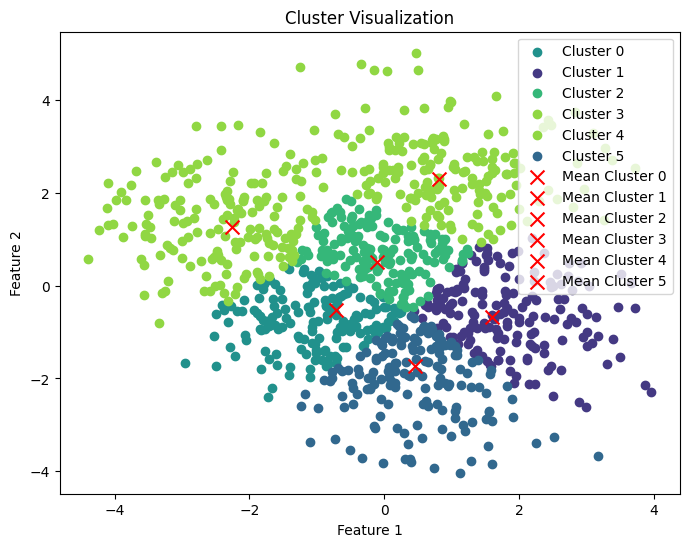

In [23]:
m,s2,phi=VI(X,K,sigma,10000,10)
print(m,'\n',mu)
print(s2)
print(phi,'\n',C)
plot_clusters(X, phi, m)